---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 2. Use it to complete the assignment by following the instructions provided in each section. Each section includes a text cell outlining the requirements. For additional details, refer to Canvas.

If you are using Google Colab, you can use the cell below to download and unzip the data.
If you are running on your computer, you will need to do this yourself.

In [ ]:
# we are using google collab zip extraction lower, so this one is of no use to us
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip UCMerced_LandUse.zip

--2025-04-03 03:12:32--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip.1’

UCMerced_LandUse.zi 100%[===================>] 317.07M  11.5MB/s    in 37s     

2025-04-03 03:13:09 (8.67 MB/s) - ‘UCMerced_LandUse.zip.1’ saved [332468434/332468434]

Archive:  UCMerced_LandUse.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of UCMerced_LandUse.zip or
        UCMerced_LandUse.zip.zip, and cannot find UCMerced_LandUse.zip

Use this first cell to import the necessary libraries.

In [ ]:
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import torchvision.models as models
from PIL import Image
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedKFold, train_test_split
from collections import Counter
import ssl
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
from tqdm import tqdm
from torchvision.models import resnet18, ResNet18_Weights

# 1. **Data Management**


In this part, you need to:

1.  define your experimental protocol (such as k-fold, cross validation, etc)
2.	create the dataloader to load the data; remember to include here any normalization, data augmentation, or other technique used to pre-process the data


Using device: cuda
Dataset found at: /content/data/UCMerced_LandUse/Images
Any overlap between train and val: False
Any overlap between train and test: False
Any overlap between val and test: False
Training size: 1512 | Validation size: 378 | Test size: 210

Training Set Class Distribution:
agricultural        : 72 samples
airplane            : 72 samples
baseballdiamond     : 72 samples
beach               : 72 samples
buildings           : 72 samples
chaparral           : 72 samples
denseresidential    : 72 samples
forest              : 72 samples
freeway             : 72 samples
golfcourse          : 72 samples
harbor              : 72 samples
intersection        : 72 samples
mediumresidential   : 72 samples
mobilehomepark      : 72 samples
overpass            : 72 samples
parkinglot          : 72 samples
river               : 72 samples
runway              : 72 samples
sparseresidential   : 72 samples
storagetanks        : 72 samples
tenniscourt         : 72 samples

Validation Set

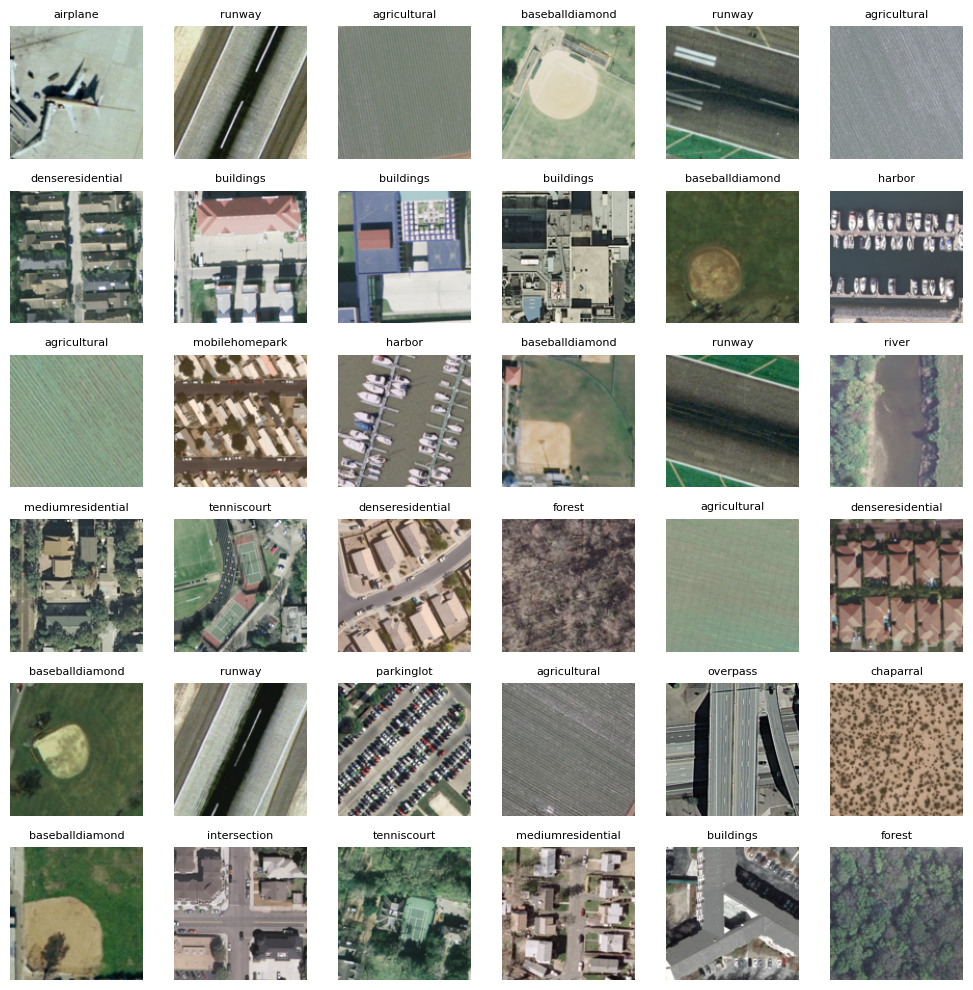

In [ ]:

# fixing the seed so output doesn't change each run
torch.manual_seed(42)
np.random.seed(42)

# checking whether gpu or cpu is used when training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# data paths
zip_path = "/content/UCMerced_LandUse.zip"
extract_path = "/content/data"

# extracting the data from zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# dataset path inside extracted ZIP
dataset_path = "/content/data/UCMerced_LandUse/Images"

# checking whether exists
if os.path.exists(dataset_path):
    print("Dataset found at:", dataset_path)
else:
    raise FileNotFoundError("Check your ZIP structure or path!")

# Extracting zip on computer, if no access to google colab

# zip_path = "UCMerced_LandUse.zip"
# extract_path = "./data" # creating /data/UCMerced_LandUse

# # Extract the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# # Confirm correct extraction
# dataset_path = "./data/UCMerced_LandUse/Images"
# if os.path.exists(dataset_path):
#     print("Dataset found at:", dataset_path)
# else:
#     raise FileNotFoundError("Dataset folder not found, check ZIP contents.")


# Define separate transforms for training and evaluation with optimal image size (128x128)
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # rotating images +- 10 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# loading the dataset without transforms first to get class info and perform stratified splits
full_dataset = ImageFolder(root=dataset_path, transform=None)
class_names = full_dataset.classes
targets = full_dataset.targets

# stratified split for test set
train_val_indices, test_indices = train_test_split(
    np.arange(len(full_dataset)),
    test_size=0.1,
    shuffle=True,
    stratify=targets,
    random_state=42
)

# stratified split for train/val
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=0.2,  # 20% of train_val becomes validation
    shuffle=True,
    stratify=[targets[i] for i in train_val_indices],
    random_state=42
)

# verification code for data leak
print(f"Any overlap between train and val: {bool(set(train_indices) & set(val_indices))}")
print(f"Any overlap between train and test: {bool(set(train_indices) & set(test_indices))}")
print(f"Any overlap between val and test: {bool(set(val_indices) & set(test_indices))}")


# creating dataset subsets with appropriate transforms
train_dataset = ImageFolder(root=dataset_path, transform=train_transform)
val_dataset = ImageFolder(root=dataset_path, transform=eval_transform)
test_dataset = ImageFolder(root=dataset_path, transform=eval_transform)

train_set = Subset(train_dataset, train_indices)
val_set = Subset(val_dataset, val_indices)
test_set = Subset(test_dataset, test_indices)

# creating data loaders with optimal batch size (16)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# printing dataset sizes
print(f"Training size: {len(train_set)} | Validation size: {len(val_set)} | Test size: {len(test_set)}")

# printing class distributions for all splits to check whether data distributed equally or not
for name, dataset_split, indices in [
    ("Training", train_set, train_indices),
    ("Validation", val_set, val_indices),
    ("Test", test_set, test_indices)
]:
    class_counts = Counter([targets[i] for i in indices])
    print(f"\n{name} Set Class Distribution:")
    for idx, cls in enumerate(class_names):
        print(f"{cls:20s}: {class_counts[idx]} samples")

# visualising sample training images (using unnormalized images for better visualization)
# creating a temporary dataset without normalization for visualisation
vis_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Using the optimal image size
    transforms.ToTensor(),  # No normalization for visualization
])
vis_dataset = ImageFolder(root=dataset_path, transform=vis_transform)
vis_train_set = Subset(vis_dataset, train_indices[:36])  # Just use the first 36 images for visualization

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 6
for i in range(1, cols * rows + 1):
    if i <= len(vis_train_set):
        img, label = vis_train_set[i-1]
        figure.add_subplot(rows, cols, i)
        plt.title(class_names[label], fontsize=8)
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))  # converting from CHW to HWC format for display
plt.tight_layout()
plt.show()

---

# 2. **Neural Networks**

Here, you need to:

1.	propose your own Convolutional Neural Network (CNN) to tackle the problem;
2.	define at least one existing CNN (such as AlexNet, VGG, ResNet, DenseNet, etc) to tackle the problem;
3.	define the necessary components to train the networks (that is, loss function, optimizers, etc);
4.	train your proposed architecture from scratch using your training set;
5.	train the existing architecture using at least 2 different strategies (i.e., trained from scratch, fine-tuning, feature extractor, etc);
6.	for all training procedures, separately plot the loss and accuracy with respect to the epoch/iteration.



Epoch 1/25 - Train Loss: 2.9865, Train Acc: 0.1157, Val Loss: 2.6912, Val Acc: 0.1481
Epoch 2/25 - Train Loss: 2.3180, Train Acc: 0.2804, Val Loss: 2.0388, Val Acc: 0.3439
Epoch 3/25 - Train Loss: 1.8210, Train Acc: 0.4114, Val Loss: 1.8527, Val Acc: 0.4127
Epoch 4/25 - Train Loss: 1.5628, Train Acc: 0.4841, Val Loss: 1.4587, Val Acc: 0.5106
Epoch 5/25 - Train Loss: 1.3144, Train Acc: 0.5728, Val Loss: 1.2193, Val Acc: 0.5952
Epoch 6/25 - Train Loss: 1.1559, Train Acc: 0.6270, Val Loss: 1.2571, Val Acc: 0.5794
Epoch 7/25 - Train Loss: 1.0976, Train Acc: 0.6343, Val Loss: 1.1783, Val Acc: 0.6190
Epoch 8/25 - Train Loss: 0.7615, Train Acc: 0.7546, Val Loss: 1.0772, Val Acc: 0.6667
Epoch 9/25 - Train Loss: 0.6815, Train Acc: 0.7890, Val Loss: 1.0552, Val Acc: 0.6720
Epoch 10/25 - Train Loss: 0.6442, Train Acc: 0.7758, Val Loss: 1.0651, Val Acc: 0.6720
Epoch 11/25 - Train Loss: 0.6102, Train Acc: 0.7943, Val Loss: 1.0148, Val Acc: 0.6958
Epoch 12/25 - Train Loss: 0.5950, Train Acc: 0.8128,

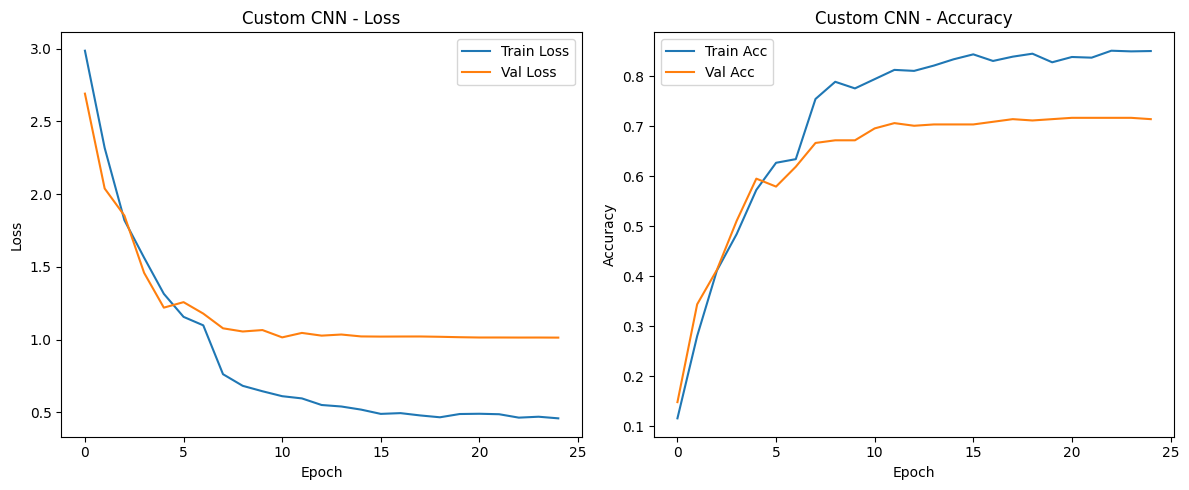

In [ ]:
# optimised costum CNN architecture based on best hyperparameters found in our tests
class CustomCNN(nn.Module):
    def __init__(self, num_classes=21):
        super(CustomCNN, self).__init__()
        # using the best convolutional channels: [64, 128, 256]
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )

        # calculating the flattened size based on input dimensions
        # for 128x128 input, after 3 max pooling layers, the feature map size is 16x16
        feature_size = 16
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * feature_size * feature_size, 256),  # best FC units: 256
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),  # best dropout rate: 0.3
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# training function with added training accuracy display
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_acc = 0.0
    best_model_wts = model.state_dict()

    # looping through epochs
    for epoch in range(num_epochs):
        # training phase
        model.train()
        running_loss, running_corrects = 0.0, 0
        total_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = inputs.size(0)
            total_samples += batch_size

            # forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward pass and optimise
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels.data).item()

        if scheduler:
            scheduler.step()

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # validation phase
        model.eval()
        running_loss, running_corrects = 0.0, 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                batch_size = inputs.size(0)
                total_samples += batch_size
                outputs = model(inputs)  # forward pass
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

        # saving the best model
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            best_model_wts = model.state_dict()

    # loading best model weights
    model.load_state_dict(best_model_wts)
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies
    }

# function to evaluate the model on test set
def evaluate_model(model, test_loader):
    model.eval()
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = inputs.size(0)
            total_samples += batch_size
            outputs = model(inputs)   # forward pass
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()

    accuracy = running_corrects / total_samples
    print(f"Test Accuracy: {accuracy:.4f}")

    return accuracy

# plotting the  metrics
def plot_metrics(metrics, title_prefix):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.plot(metrics['val_losses'], label='Val Loss')
    plt.title(f"{title_prefix} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_accuracies'], label='Train Acc')
    plt.plot(metrics['val_accuracies'], label='Val Acc')
    plt.title(f"{title_prefix} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# creating the optimised model
model = CustomCNN(num_classes=len(class_names))
criterion = nn.CrossEntropyLoss()

# setting the optimal learning rate and weight decay from hyperparameter tuning
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # decreasing learning rate every 7 epochs to stablilise

# training and plotting the model
trained_model, metrics = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25)
plot_metrics(metrics, "Custom CNN")



Creating ResNet18 model - Training from scratch
Training ResNet18 Model from scratch
Epoch 1/25 - Train Loss: 2.6004, Train Acc: 0.2249, Val Loss: 3.3260, Val Acc: 0.1878
Epoch 2/25 - Train Loss: 2.1089, Train Acc: 0.3261, Val Loss: 1.8401, Val Acc: 0.3836
Epoch 3/25 - Train Loss: 1.8125, Train Acc: 0.4120, Val Loss: 1.8218, Val Acc: 0.4762
Epoch 4/25 - Train Loss: 1.5145, Train Acc: 0.4835, Val Loss: 1.8406, Val Acc: 0.4762
Epoch 5/25 - Train Loss: 1.4159, Train Acc: 0.5304, Val Loss: 1.3890, Val Acc: 0.5503
Epoch 6/25 - Train Loss: 1.2896, Train Acc: 0.5780, Val Loss: 1.3819, Val Acc: 0.5450
Epoch 7/25 - Train Loss: 1.1915, Train Acc: 0.6078, Val Loss: 0.9217, Val Acc: 0.6931
Epoch 8/25 - Train Loss: 0.7922, Train Acc: 0.7335, Val Loss: 0.6866, Val Acc: 0.7646
Epoch 9/25 - Train Loss: 0.6748, Train Acc: 0.7870, Val Loss: 0.6743, Val Acc: 0.7884
Epoch 10/25 - Train Loss: 0.6113, Train Acc: 0.8181, Val Loss: 0.6240, Val Acc: 0.7989
Epoch 11/25 - Train Loss: 0.5444, Train Acc: 0.8241, V

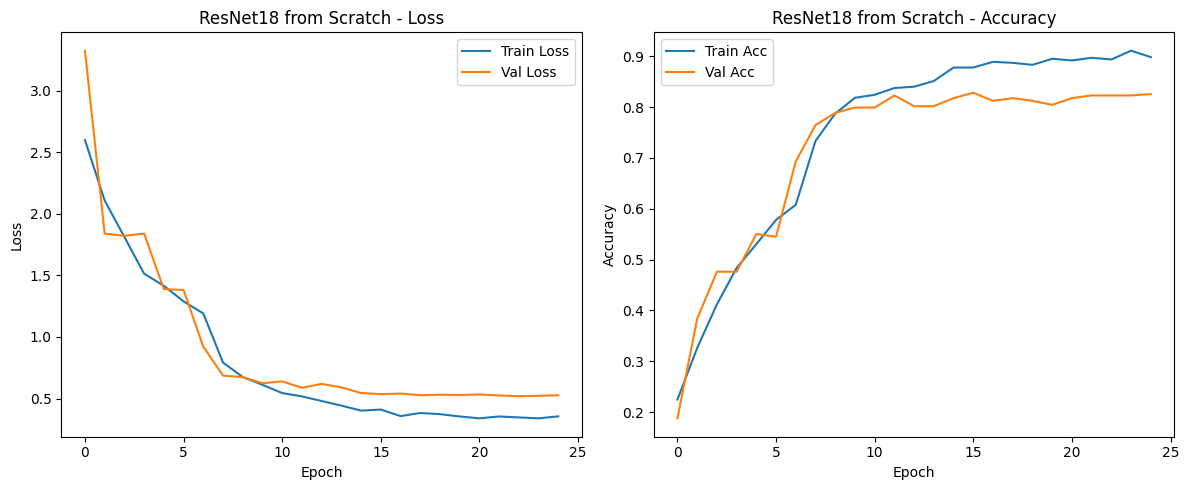

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Creating ResNet18 model - Fine-tuning


100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


Training ResNet18 Model with fine-tuning
Epoch 1/25 - Train Loss: 1.5580, Train Acc: 0.5423, Val Loss: 0.8802, Val Acc: 0.7460
Epoch 2/25 - Train Loss: 0.9336, Train Acc: 0.7090, Val Loss: 0.8555, Val Acc: 0.8016
Epoch 3/25 - Train Loss: 0.7794, Train Acc: 0.7566, Val Loss: 0.4878, Val Acc: 0.8492
Epoch 4/25 - Train Loss: 0.5775, Train Acc: 0.8208, Val Loss: 0.6767, Val Acc: 0.8069
Epoch 5/25 - Train Loss: 0.5328, Train Acc: 0.8360, Val Loss: 0.3640, Val Acc: 0.9074
Epoch 6/25 - Train Loss: 0.4545, Train Acc: 0.8598, Val Loss: 0.8703, Val Acc: 0.7460
Epoch 7/25 - Train Loss: 0.4725, Train Acc: 0.8558, Val Loss: 0.4505, Val Acc: 0.8677
Epoch 8/25 - Train Loss: 0.2299, Train Acc: 0.9233, Val Loss: 0.1615, Val Acc: 0.9471
Epoch 9/25 - Train Loss: 0.1414, Train Acc: 0.9616, Val Loss: 0.1328, Val Acc: 0.9550
Epoch 10/25 - Train Loss: 0.1072, Train Acc: 0.9716, Val Loss: 0.1292, Val Acc: 0.9577
Epoch 11/25 - Train Loss: 0.1108, Train Acc: 0.9683, Val Loss: 0.0934, Val Acc: 0.9709
Epoch 12/25

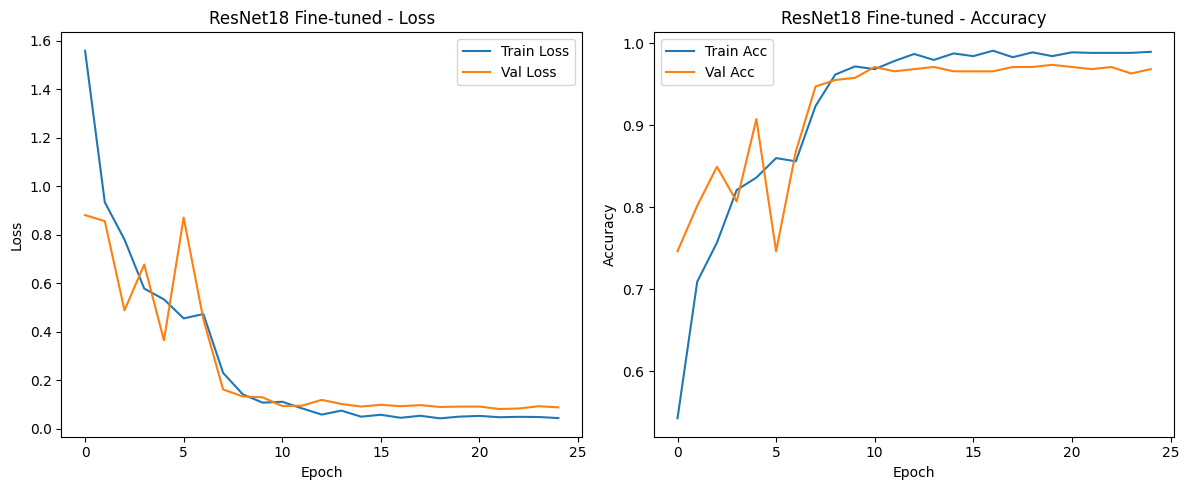

In [ ]:
# creating a unverified SSL context to bypass certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

# Strategy 1: ResNet18 trained from scratch
print("Creating ResNet18 model - Training from scratch")
resnet18_scratch = models.resnet18(weights=None)  # No pre-trained weights
resnet18_scratch.fc = nn.Linear(resnet18_scratch.fc.in_features, len(class_names))

# setting up optimizer and scheduler for ResNet18 from scratch
optimizer_resnet_scratch = optim.Adam(resnet18_scratch.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_resnet_scratch = optim.lr_scheduler.StepLR(optimizer_resnet_scratch, step_size=7, gamma=0.1)

# training ResNet18 model from scratch
print("Training ResNet18 Model from scratch")
trained_resnet18_scratch, resnet18_scratch_metrics = train_model(
    resnet18_scratch, train_loader, val_loader,
    criterion, optimizer_resnet_scratch, scheduler_resnet_scratch,
    num_epochs=25
)

# printing training and validation accuracy for ResNet18 from scratch
print("ResNet18 from Scratch - Final Metrics:")
print(f"Training Accuracy: {resnet18_scratch_metrics['train_accuracies'][-1]:.4f}")
print(f"Validation Accuracy: {resnet18_scratch_metrics['val_accuracies'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(resnet18_scratch_metrics['val_accuracies']):.4f}")

# plotting the metrics for ResNet18 from scratch
plot_metrics(resnet18_scratch_metrics, "ResNet18 from Scratch")

# Strategy 2: ResNet18 with fine-tuning
print("Creating ResNet18 model - Fine-tuning")
resnet18_finetune = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18_finetune.fc = nn.Linear(resnet18_finetune.fc.in_features, len(class_names))

# setting up optimizer and scheduler for ResNet18 fine-tuning
optimizer_resnet_finetune = optim.Adam(resnet18_finetune.parameters(), lr=0.001, weight_decay=1e-4)
scheduler_resnet_finetune = optim.lr_scheduler.StepLR(optimizer_resnet_finetune, step_size=7, gamma=0.1)

# training fine-tuned ResNet18 model
print("Training ResNet18 Model with fine-tuning")
trained_resnet18_finetune, resnet18_finetune_metrics = train_model(
    resnet18_finetune, train_loader, val_loader,
    criterion, optimizer_resnet_finetune, scheduler_resnet_finetune,
    num_epochs=25
)

# printing training and validation accuracy for fine-tuned ResNet18
print("ResNet18 Fine-tuned - Final Metrics:")
print(f"Training Accuracy: {resnet18_finetune_metrics['train_accuracies'][-1]:.4f}")
print(f"Validation Accuracy: {resnet18_finetune_metrics['val_accuracies'][-1]:.4f}")
print(f"Best Validation Accuracy: {max(resnet18_finetune_metrics['val_accuracies']):.4f}")

# plotting the metrics for fine-tuned ResNet18
plot_metrics(resnet18_finetune_metrics, "ResNet18 Fine-tuned")

---

# 3. **Evaluate models**

Here, you need to:

1.	evaluate the model (the best one you obtained in the above stage) on the testing dataset.


Complete Model Comparison 
Custom CNN:
 Final Training Accuracy: 0.8505
 Final Validation Accuracy: 0.7143
 Best Validation Accuracy: 0.7169

ResNet18 (from scratch):
 Final Training Accuracy: 0.8981
 Final Validation Accuracy: 0.8254
 Best Validation Accuracy: 0.8280

ResNet18 (fine-tuned):
 Final Training Accuracy: 0.9894
 Final Validation Accuracy: 0.9683
 Best Validation Accuracy: 0.9735


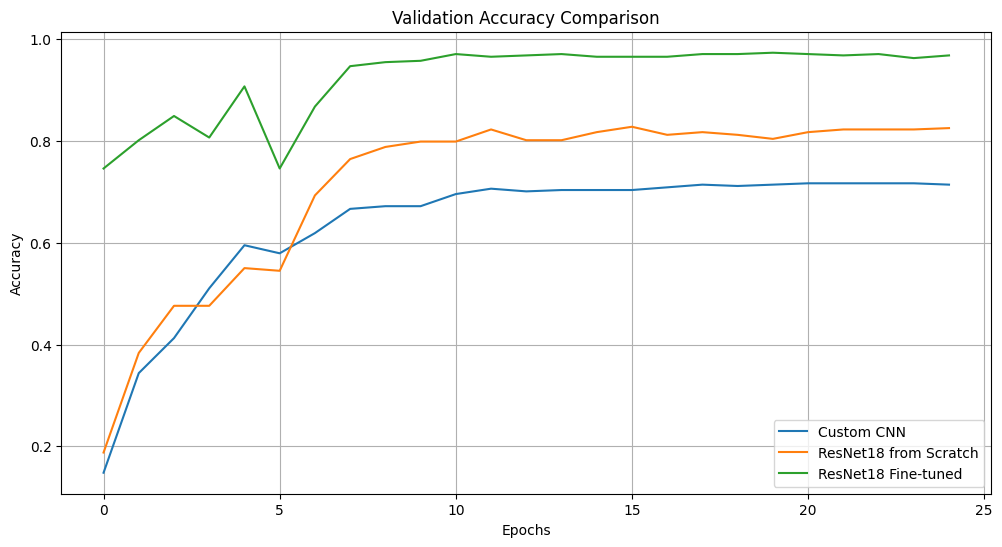

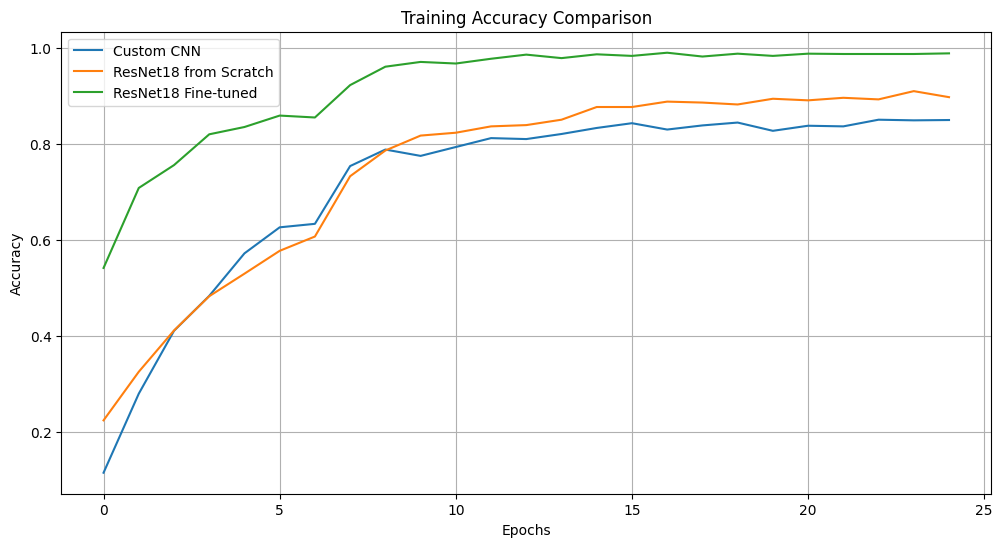

Best performing model: ResNet18 Fine-tuned with validation accuracy 0.9735


In [ ]:
# comparing all models
print("Complete Model Comparison ")
custom_best_acc = max(metrics['val_accuracies'])
resnet_scratch_best_acc = max(resnet18_scratch_metrics['val_accuracies'])
resnet_finetune_best_acc = max(resnet18_finetune_metrics['val_accuracies'])

print(f"Custom CNN:")
print(f" Final Training Accuracy: {metrics['train_accuracies'][-1]:.4f}")
print(f" Final Validation Accuracy: {metrics['val_accuracies'][-1]:.4f}")
print(f" Best Validation Accuracy: {custom_best_acc:.4f}")
print()

print(f"ResNet18 (from scratch):")
print(f" Final Training Accuracy: {resnet18_scratch_metrics['train_accuracies'][-1]:.4f}")
print(f" Final Validation Accuracy: {resnet18_scratch_metrics['val_accuracies'][-1]:.4f}")
print(f" Best Validation Accuracy: {resnet_scratch_best_acc:.4f}")
print()

print(f"ResNet18 (fine-tuned):")
print(f" Final Training Accuracy: {resnet18_finetune_metrics['train_accuracies'][-1]:.4f}")
print(f" Final Validation Accuracy: {resnet18_finetune_metrics['val_accuracies'][-1]:.4f}")
print(f" Best Validation Accuracy: {resnet_finetune_best_acc:.4f}")

# visualising the comparison of validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(metrics['val_accuracies'], label='Custom CNN')
plt.plot(resnet18_scratch_metrics['val_accuracies'], label='ResNet18 from Scratch')
plt.plot(resnet18_finetune_metrics['val_accuracies'], label='ResNet18 Fine-tuned')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('validation_accuracy_comparison.png')
plt.show()

# visualising the comparison of training accuracies
plt.figure(figsize=(12, 6))
plt.plot(metrics['train_accuracies'], label='Custom CNN')
plt.plot(resnet18_scratch_metrics['train_accuracies'], label='ResNet18 from Scratch')
plt.plot(resnet18_finetune_metrics['train_accuracies'], label='ResNet18 Fine-tuned')
plt.title('Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy_comparison.png')
plt.show()

# evaluating the best model on test set
# determine which model performed best on validation
best_model = None
best_name = ""
best_acc = 0

if custom_best_acc > best_acc:
    best_model = trained_model
    best_name = "Custom CNN"
    best_acc = custom_best_acc

if resnet_scratch_best_acc > best_acc:
    best_model = trained_resnet18_scratch
    best_name = "ResNet18 from Scratch"
    best_acc = resnet_scratch_best_acc

if resnet_finetune_best_acc > best_acc:
    best_model = trained_resnet18_finetune
    best_name = "ResNet18 Fine-tuned"
    best_acc = resnet_finetune_best_acc

print(f"Best performing model: {best_name} with validation accuracy {best_acc:.4f}")



resnet18_finetune Test Accuracy: 0.9381
resnet18_finetune Test Loss: 0.2039
resnet18_finetune Classification Report:
agricultural        : Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
airplane            : Precision: 1.0000, Recall: 0.9000, F1-Score: 0.9474
baseballdiamond     : Precision: 0.9091, Recall: 1.0000, F1-Score: 0.9524
beach               : Precision: 0.9091, Recall: 1.0000, F1-Score: 0.9524
buildings           : Precision: 0.8182, Recall: 0.9000, F1-Score: 0.8571
chaparral           : Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
denseresidential    : Precision: 0.9000, Recall: 0.9000, F1-Score: 0.9000
forest              : Precision: 0.9091, Recall: 1.0000, F1-Score: 0.9524
freeway             : Precision: 0.9091, Recall: 1.0000, F1-Score: 0.9524
golfcourse          : Precision: 1.0000, Recall: 0.7000, F1-Score: 0.8235
harbor              : Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000
intersection        : Precision: 1.0000, Recall: 1.0000, F1-Score: 1.

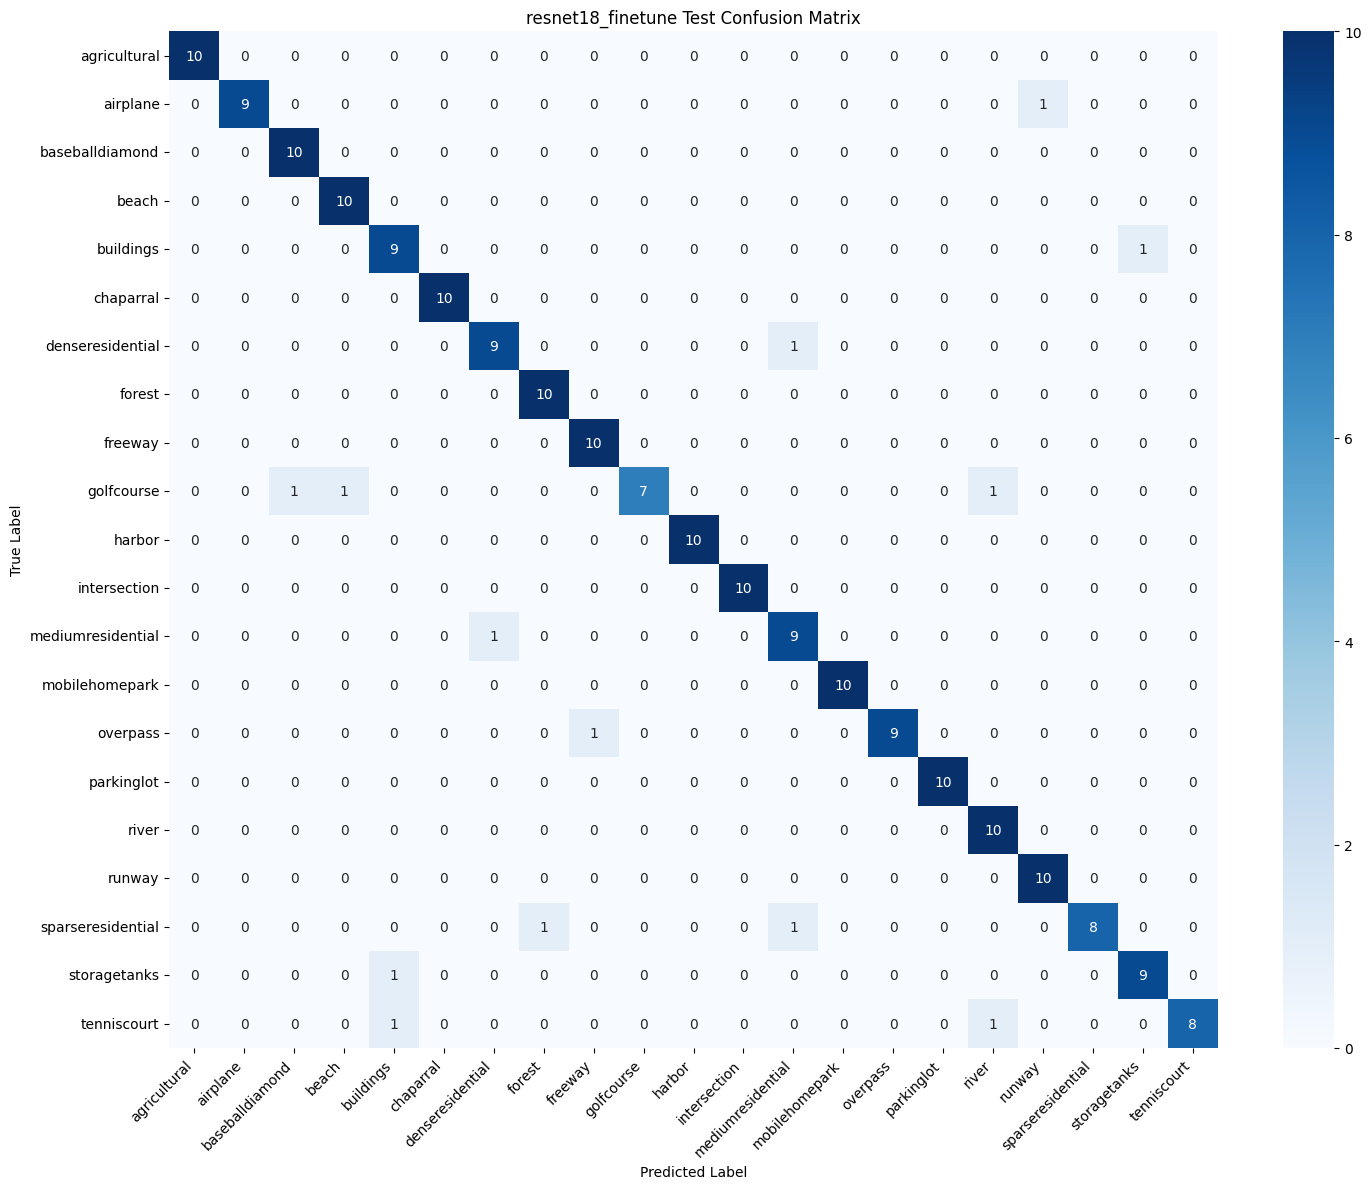

In [ ]:
# evaluating resnet18_finetune on the test set, as it is the best model we obtained
def evaluate_model(model, test_loader, criterion, class_names):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)

    return test_loss, test_acc, report, cm, all_preds, all_labels
# evaluating the trained model on the test set
test_loss, test_acc, classification_rep, conf_mat, predictions, true_labels = evaluate_model(
    resnet18_finetune, test_loader, criterion, class_names
)
print(f"resnet18_finetune Test Accuracy: {test_acc:.4f}")
print(f"resnet18_finetune Test Loss: {test_loss:.4f}")

print("resnet18_finetune Classification Report:")
for cls in class_names:
    print(f"{cls:20s}: Precision: {classification_rep[cls]['precision']:.4f}, "
          f"Recall: {classification_rep[cls]['recall']:.4f}, "
          f"F1-Score: {classification_rep[cls]['f1-score']:.4f}")

print(f"Macro F1-Score: {classification_rep['macro avg']['f1-score']:.4f}")
print(f"Weighted F1-Score: {classification_rep['weighted avg']['f1-score']:.4f}")

# plotting confusion matrix
def plot_confusion_matrix(cm, class_names, title):
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
# plotting confusion matrix for ResNet18
plot_confusion_matrix(conf_mat, class_names, "resnet18_finetune Test Confusion Matrix")